## 신용카드 사기거래 문제
- AutoEncoder 활용해서 사기거래 검출하기
  - 학습 : 정상 데이터(label, 0)로만 학습 후, 복원
  - 테스트 : 정상, 비정상 포함

## 01 라이브러리, 데이터 불러오기

#### 01-01 라이브러리, 하이퍼파라미터

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 01-02 데이터 살펴보기

In [ ]:
import os

base_path = '/content/drive/MyDrive/AI_serivce_track/Week_03'

# 정확한 이름으로 다시 할당
data_path = os.path.join(base_path, 'creditcard.csv')
creditcard_df = pd.read_csv(data_path)
creditcard_df.shape

(284807, 31)

In [ ]:
# 데이터 5개만 살펴보기
creditcard_df.head() # n=5로 직접설정해도 되지만 기본값이 5개임

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
creditcard_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### 02 데이터 결측치/이상치/분포 확인
- 전처리 로직 확립 위해 데이터 결측치/이상치/분포 확인
- 전처리 로직
  - 결측치/이상치
    - 결측치 존재하지 않음
    - 이상치 따로 제거 안함(StandardScaler사용)
  - 불필요 컬럼 Time 제거
  - Amount컬럼 전처리
    - 시각화해보니, log취하고, StandardScaler 사용

#### 02-01 결측치, 이상치 체크
- 다행히 결측치는 존재하지 않음

##### 결측치 확인

In [ ]:
# 결측치 확인하기
creditcard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
creditcard_df.isnull().mean()

,0
Time,0.0
V1,0.0
V2,0.0
V3,0.0
V4,0.0
V5,0.0
V6,0.0
V7,0.0
V8,0.0
V9,0.0


#### 02-02 데이터 특징 살펴보기

##### v1~v28의 분포
- PCA로 처리된 컬럼들의 분포 살펴보기
- 각 컬럼별로 scale이 다르므로 standard-scaler로 맞춰주는 것이 나아보임
  - auto-encoder는 scale에 예민함(MLP포함 딥러닝 아키텍쳐들이 대개 그렇듯이......)

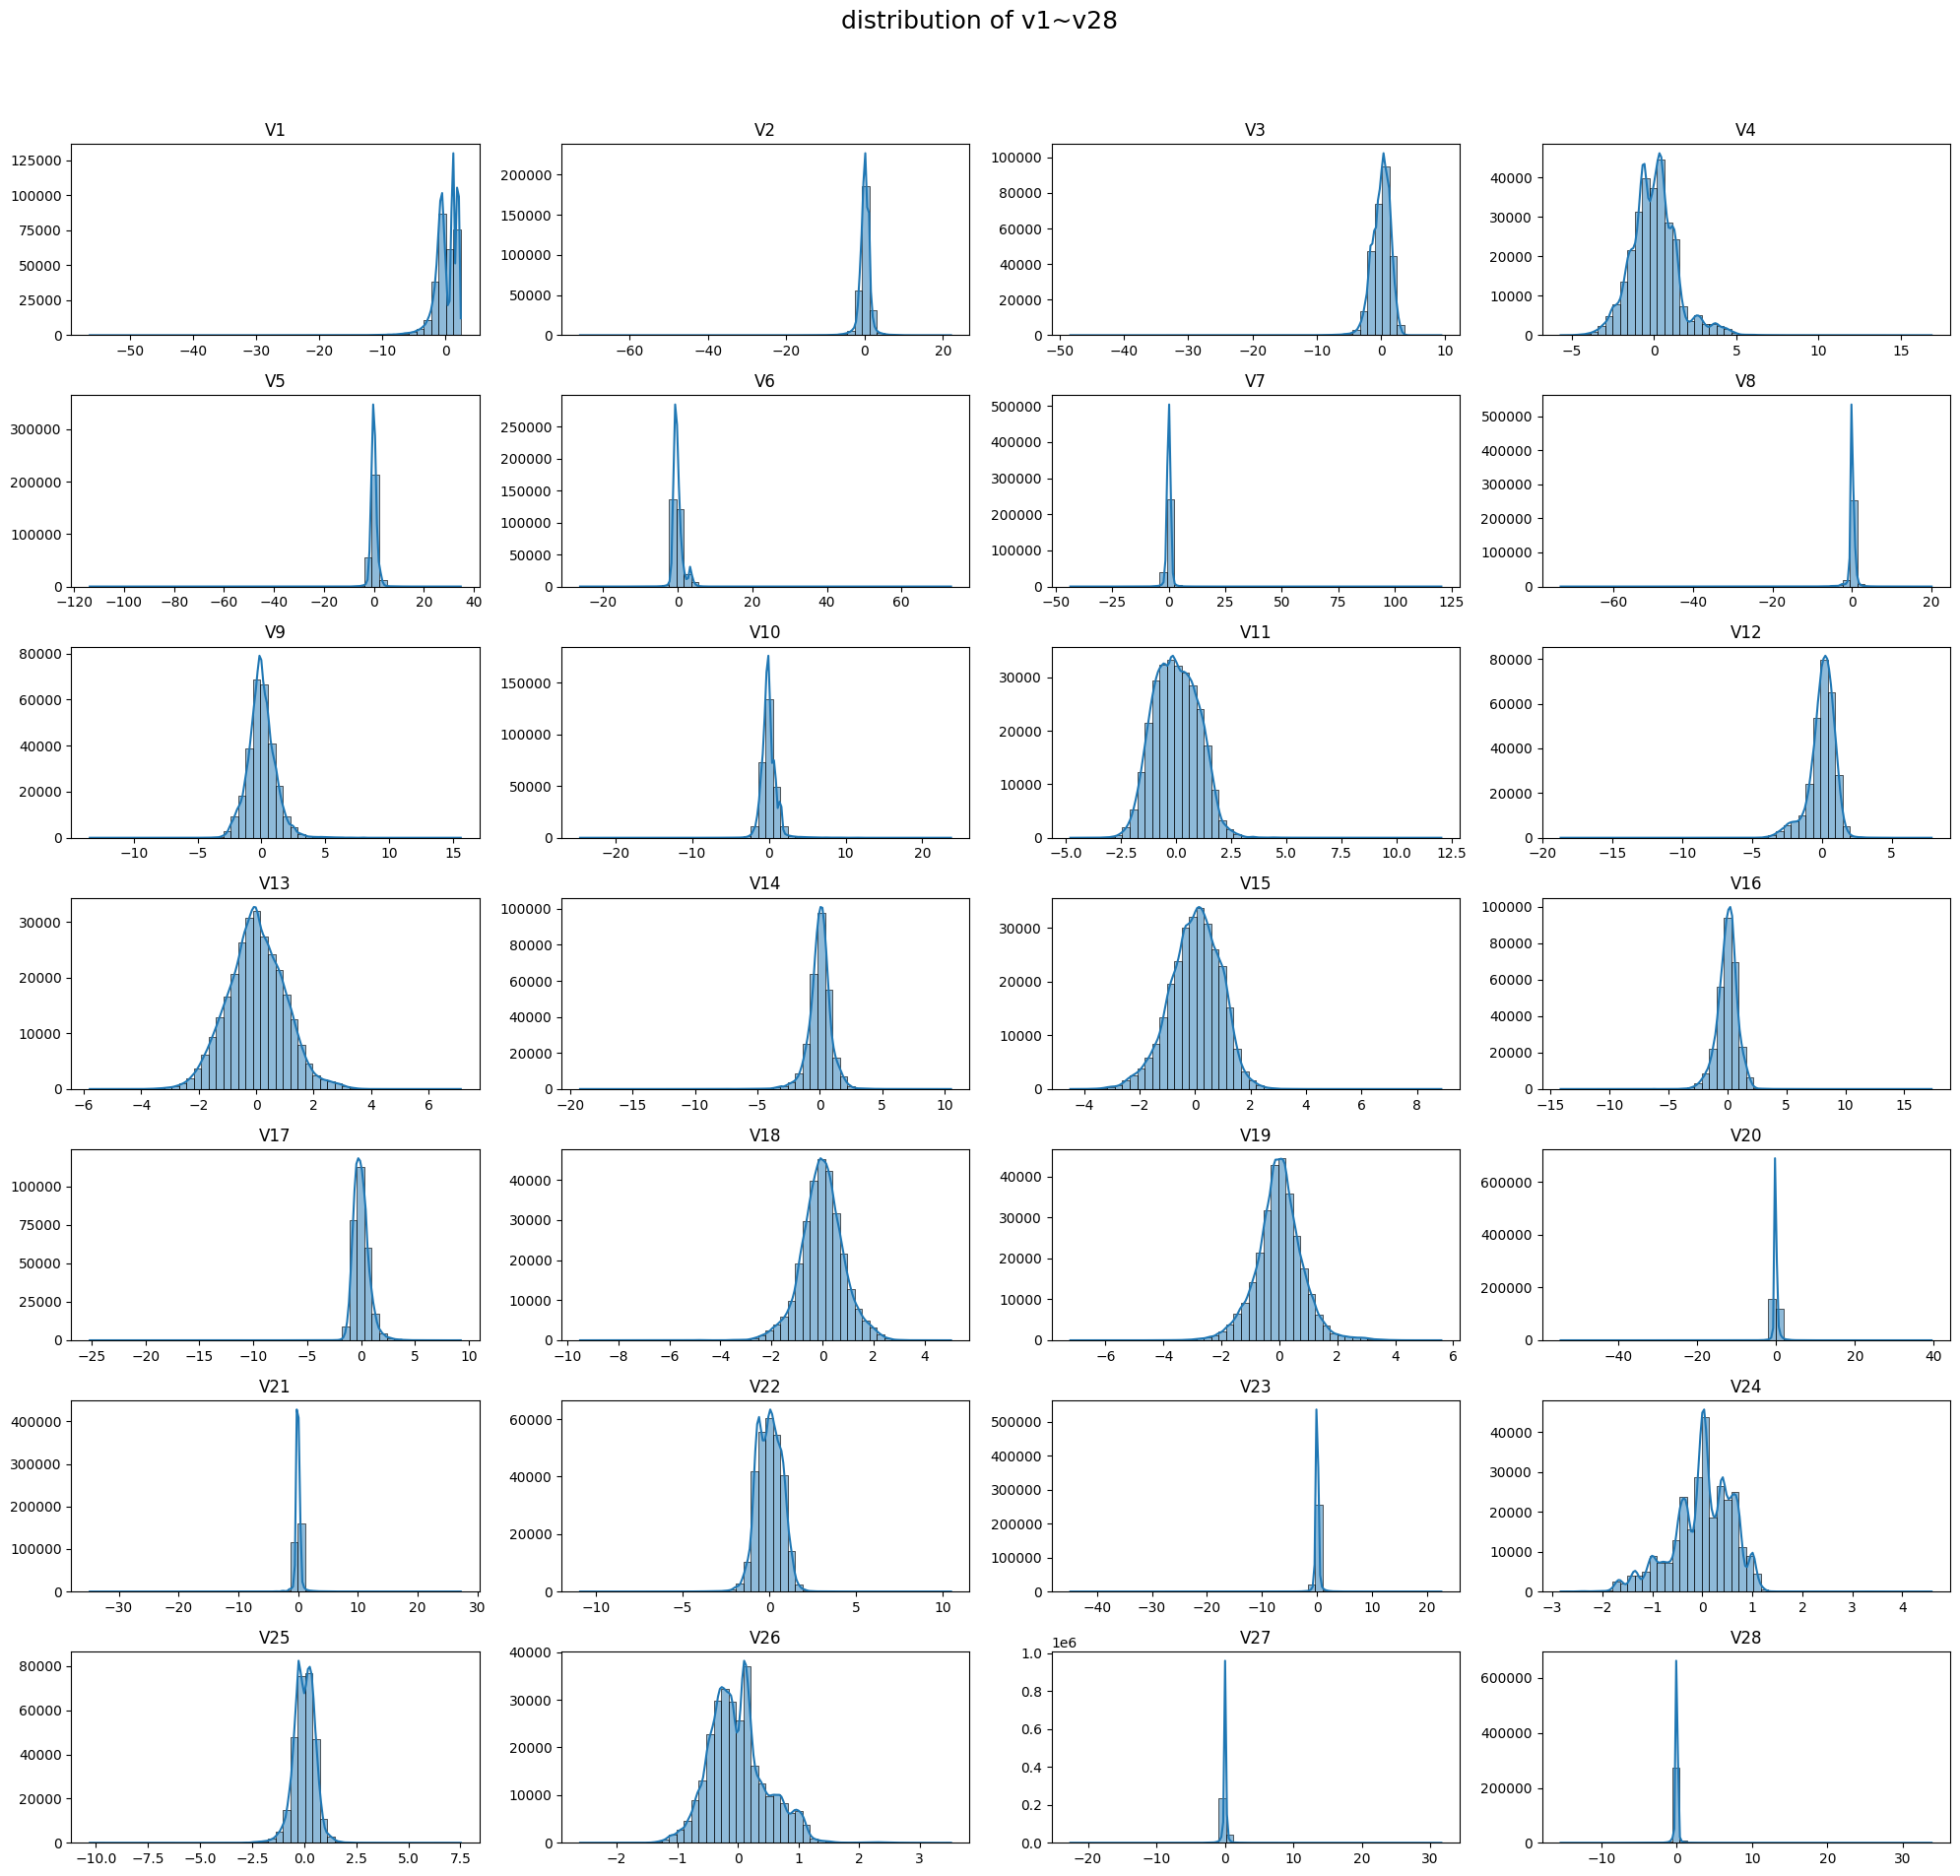

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# creditcard_df 데이터 사용
# V1 ~ V28 컬럼 선택
v_features = creditcard_df.iloc[:, 1:29] # Class와 Time을 제외한 V1~V28

# 그래프 그리기
plt.figure(figsize = (20,20))
plt.suptitle('distribution of v1~v28', fontsize = 18)

for i, feature in enumerate(v_features):
    plt.subplot(7,4, i+1)
    # kde는 비모수적인 커널을 그려주는 것
    sns.histplot(v_features[feature], bins=50, kde = True)
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()


##### creditcard 데이터 label분포
- 0(정상) 284,315건, 1(사기) 492건
  - 전체 284,807건에서 사기거래가 492건이므로 약 0.17% 의 class비율
  - imbalance(불균형)이 극심해서 딥러닝, 머신러닝 알고리즘 바로 적용하기에 제한 있음

In [ ]:
creditcard_df['Class'].value_counts()

,count
Class,
0,284315
1,492


##### time의 분포
- 12만건의 시점이 존재하므로, 해당 범주(수치형 데이터지만)의 cardinality가 너무 커서 분석 및 모델링에 활용 적절치 않음
- 이 컬럼은 생략 가능

In [ ]:
creditcard_df['Time'].nunique()

124592

##### amount 분포
- 시각화해보기
  - amount 분포가 극도로 치우쳐져 있음
    - 중앙값이 22고 평균이 88이라 함은 극소수의 큰 값이 존재해서 분포를
      오른쪽 꼬리가 길게 만든다는 것을 의미
  - 로그 변환후 시각화
  - 로그 변환후, 스케일링(standard-scale)

In [ ]:
creditcard_df['Amount'].describe()

,Amount
count,284807.000000
mean,88.349619
std,250.120109
min,0.000000
25%,5.600000
50%,22.000000
75%,77.165000
max,25691.160000


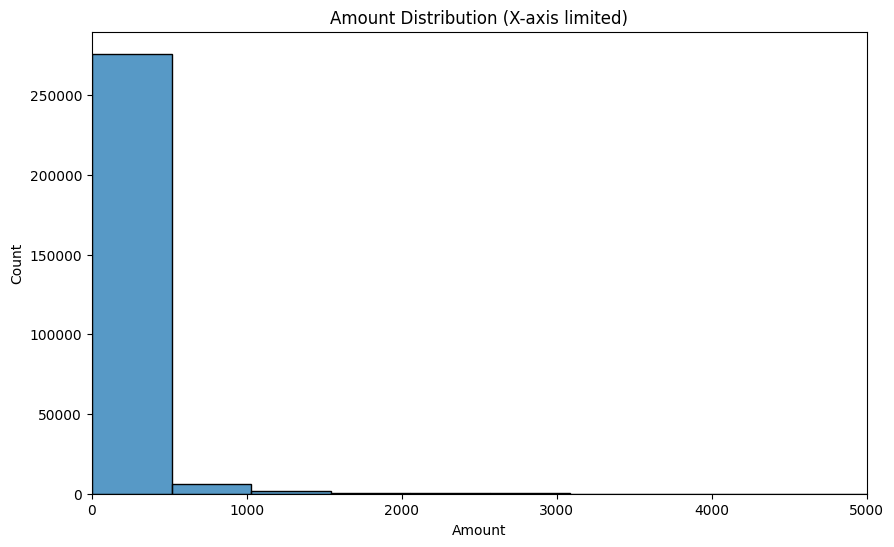

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# x축 범위를 0부터 5000 정도로 제한
plt.figure(figsize=(10, 6))
sns.histplot(creditcard_df['Amount'], bins=50)
plt.title('Amount Distribution (X-axis limited)')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.xlim(0, 5000) # x축 범위를 0~5000으로 제한
plt.show()

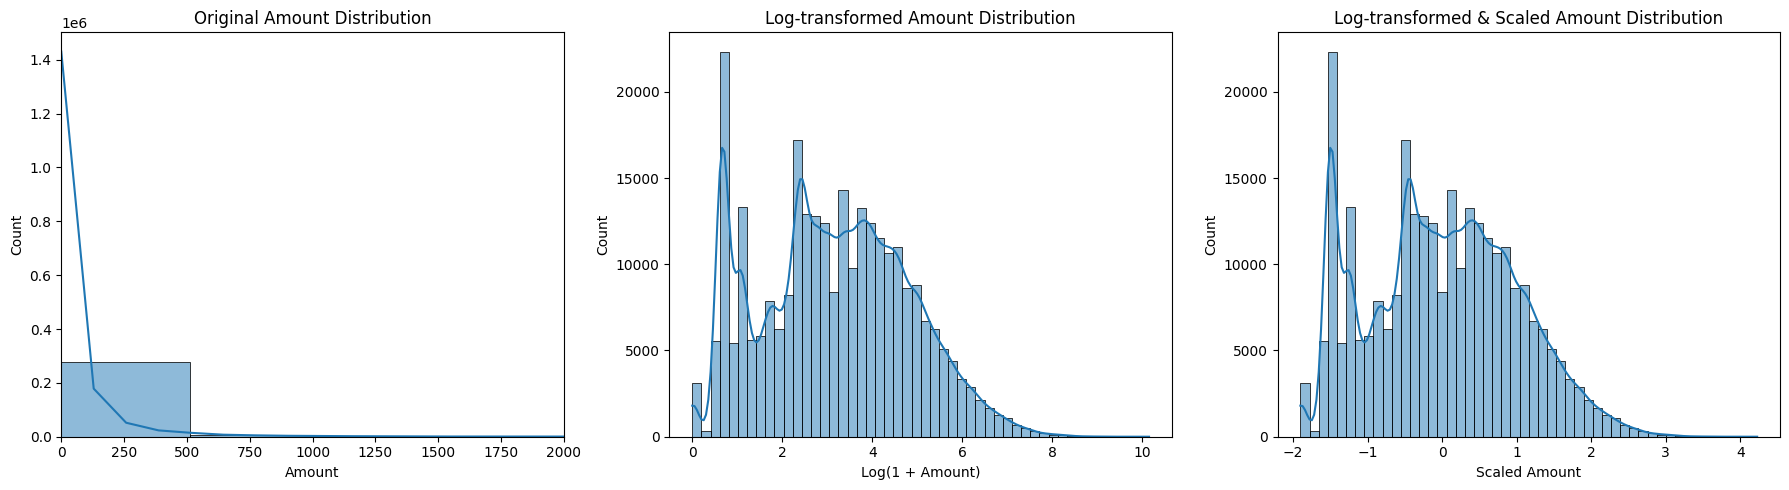

스케일링된 데이터의 평균: 9.42044742660868e-17
스케일링된 데이터의 표준편차: 1.0000017555793377


In [ ]:
# 1. 원본 Amount 컬럼의 분포 시각화
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(creditcard_df['Amount'], bins=50, kde=True)
plt.title('Original Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.xlim(0, 2000) # x축 범위 제한으로 밀집된 구간 확인

# 2. 로그 변환만 적용한 Amount 컬럼의 분포 시각화
amount_log_transformed = np.log1p(creditcard_df['Amount'])
plt.subplot(1, 3, 2)
sns.histplot(amount_log_transformed, bins=50, kde=True)
plt.title('Log-transformed Amount Distribution')
plt.xlabel('Log(1 + Amount)')
plt.ylabel('Count')

# 3. 로그 변환 후 스케일링까지 적용한 Amount 컬럼의 분포 시각화
scaler = StandardScaler()
# reshape(-1, 1)을 사용하여 1D 데이터를 2D 배열로 변환
amount_scaled = scaler.fit_transform(amount_log_transformed.values.reshape(-1, 1))
amount_scaled_series = pd.Series(amount_scaled.flatten(), name='Scaled Amount')
plt.subplot(1, 3, 3)
sns.histplot(amount_scaled_series, bins=50, kde=True)
plt.title('Log-transformed & Scaled Amount Distribution')
plt.xlabel('Scaled Amount')
plt.ylabel('Count')

plt.tight_layout() # 서브플롯 간 간격 조절
plt.show()

# 스케일링된 데이터의 평균과 표준편차 확인
print("스케일링된 데이터의 평균:", amount_scaled_series.mean())
print("스케일링된 데이터의 표준편차:", amount_scaled_series.std())

### 03 데이터 전처리

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StnadardScaler

# 1 Time 컬럼 제거
data_df = creditcard_df.drop(['Time'], axis=1)

# 2 Amount 컬럼 로그변환 후 표준화
# np.log1p 사용해서 0인 값도 안전하게 처리
data_df['Amount'] = np.log1p(data_df['Amount'])

# StnadardScaler 적용
scaler = StandardScaler()
data_scaled_features = scaler.fit_transform(data_df.drop('Class', axis=1))


### 04. 데이터 분리 및 준비
- AutoEncoder는 정상 거래(class 0)만으로 학습함

In [ ]:
# 원본 data_df에서 정상 거래(0)와 사기 거래(1)를 나누기
# 정상/사기 분리
normal_df = data_df[data_df['Class'] == 0]
fraud_df = data_df[data_df['Class'] == 1]

train_normal, val_normal = train_test_split(normal_df, test_size=0.2, random_state=42)
test_data_all = pd.concat([val_normal, fraud_df])

In [ ]:
#  DataFrame → numpy 배열로 바꾸는 이유는 torch tensor로 바꾸기 위함
train_X = train_normal.drop('Class', axis=1).values
train_y = train_normal['Class'].values

val_X = val_normal.drop('Class', axis=1).values
val_y = val_normal['Class'].values

test_X = test_data_all.drop('Class', axis=1).values
test_y = test_data_all['Class'].values

In [ ]:
#PyTorch는 학습 데이터를 tensor로 받기 때문에 numpy에서 torch로 바꿔야함
train_data_tensor = torch.tensor(train_X, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_y, dtype=torch.float32)

val_data_tensor = torch.tensor(val_X, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_y, dtype=torch.float32)

test_data_tensor = torch.tensor(test_X, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_y, dtype=torch.float32)

In [ ]:
# PyTorch 학습을 하려면 Dataset → DataLoader 구조가 필요
from torch.utils.data import Dataset, DataLoader

class CreditCardDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Dataset 만들기
train_dataset = CreditCardDataset(train_data_tensor, train_labels_tensor)
val_dataset   = CreditCardDataset(val_data_tensor, val_labels_tensor)
test_dataset  = CreditCardDataset(test_data_tensor, test_labels_tensor)

# DataLoader 만들기
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1024, shuffle=False)

### 05 오토인코더 모델 클래스 정의

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_sizes[1], hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], input_size)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

### 06 모델 Training
- Trainer 클래스 정의(수업내용 참고)

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, epochs, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.device = device
        self.history = {
            'train_loss': [], 'val_loss': []
        }

    def train(self, patience=3, min_delta=1e-4):
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0

            for x, _ in self.train_loader:
                x = x.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(x)
                loss = self.criterion(output, x)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(self.train_loader)

            # validation
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for x, _ in self.val_loader:
                    x = x.to(self.device)
                    output = self.model(x)
                    loss = self.criterion(output, x)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(self.val_loader)

            print(f"[{epoch+1}/{self.epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

            self.history['train_loss'].append(avg_train_loss)
            self.history['val_loss'].append(avg_val_loss)

            # early stopping
            if avg_val_loss < best_val_loss - min_delta:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

In [ ]:
epochs = 100
patience = 5
min_delta = 0.0003

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(input_size=train_X.shape[1], hidden_sizes=[20,10, 5]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model, train_loader, val_loader, optimizer, criterion, epochs=epochs, device=device)
trainer.train(patience=patience, min_delta=min_delta)

[1/100] Train Loss: 1.0020 | Val Loss: 0.6595
[2/100] Train Loss: 0.5326 | Val Loss: 0.4571
[3/100] Train Loss: 0.4061 | Val Loss: 0.3869
[4/100] Train Loss: 0.3611 | Val Loss: 0.3583
[5/100] Train Loss: 0.3457 | Val Loss: 0.3488
[6/100] Train Loss: 0.3406 | Val Loss: 0.3443
[7/100] Train Loss: 0.3362 | Val Loss: 0.3386
[8/100] Train Loss: 0.3302 | Val Loss: 0.3285
[9/100] Train Loss: 0.3198 | Val Loss: 0.3167
[10/100] Train Loss: 0.3115 | Val Loss: 0.3096
[11/100] Train Loss: 0.3073 | Val Loss: 0.3050
[12/100] Train Loss: 0.3043 | Val Loss: 0.3036
[13/100] Train Loss: 0.3029 | Val Loss: 0.3006
[14/100] Train Loss: 0.3018 | Val Loss: 0.3000
[15/100] Train Loss: 0.3001 | Val Loss: 0.2985
[16/100] Train Loss: 0.2994 | Val Loss: 0.2977
[17/100] Train Loss: 0.2989 | Val Loss: 0.2973
[18/100] Train Loss: 0.2986 | Val Loss: 0.2971
[19/100] Train Loss: 0.2980 | Val Loss: 0.2960
[20/100] Train Loss: 0.2973 | Val Loss: 0.2968
[21/100] Train Loss: 0.2970 | Val Loss: 0.2971
[22/100] Train Loss: 0

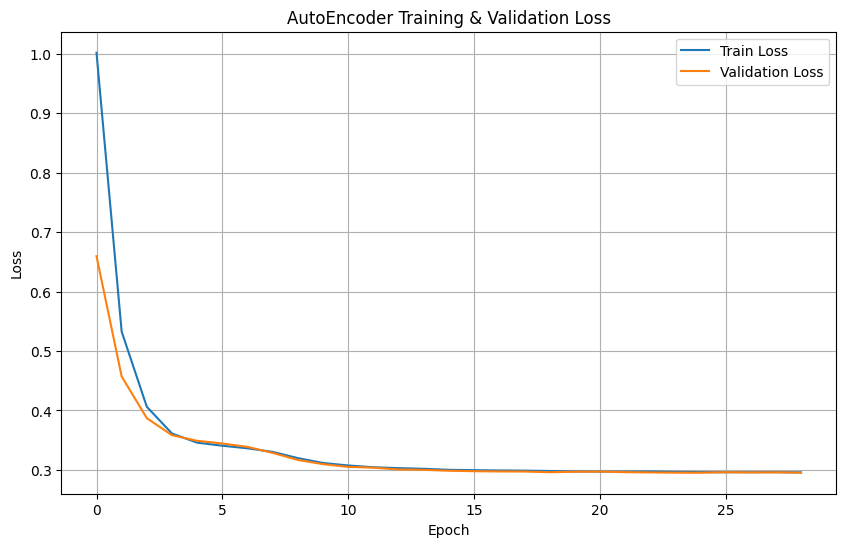

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer.history['train_loss'], label='Train Loss')
plt.plot(trainer.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('AutoEncoder Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Threshold 계산
def compute_threshold(model, loader, device, percentile=95):
    model.eval()
    errors = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            output = model(x)
            mse = torch.mean((x - output) ** 2, dim=1)
            errors.extend(mse.cpu().numpy())
    return np.percentile(errors, percentile)

threshold = compute_threshold(model, train_loader, device, percentile=95)

### 07 모델 테스트

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

class Tester:
    def __init__(self, model, data_loader, device):
        self.model = model
        self.data_loader = data_loader
        self.device = device
        self.reconstruction_errors = []
        self.y_true = []

    def calculate_errors_and_labels(self):
        self.model.eval()
        with torch.no_grad():
            for x, y in self.data_loader:
                x = x.to(self.device)
                output = self.model(x)
                mse = torch.mean((x - output) ** 2, dim=1)
                self.reconstruction_errors.extend(mse.cpu().numpy())
                self.y_true.extend(y.cpu().numpy())

        self.reconstruction_errors = np.array(self.reconstruction_errors)
        self.y_true = np.array(self.y_true)

    def evaluate(self, threshold):
        y_pred = (self.reconstruction_errors > threshold).astype(int)

        print("\n[평가 결과]")
        print(f"Threshold: {threshold:.4f}")
        print(f"Precision: {precision_score(self.y_true, y_pred):.4f}")
        print(f"Recall:    {recall_score(self.y_true, y_pred):.4f}")
        print(f"F1 Score:  {f1_score(self.y_true, y_pred):.4f}")
        print("\n[Confusion Matrix]\n", confusion_matrix(self.y_true, y_pred))
        print("\n[Classification Report]\n", classification_report(self.y_true, y_pred))

In [ ]:
# 평가 실행
tester = Tester(model, test_loader, device)
tester.calculate_errors_and_labels()
tester.evaluate(threshold)


[평가 결과]
Threshold: 0.6647
Precision: 0.1332
Recall:    0.8862
F1 Score:  0.2316

[Confusion Matrix]
 [[54026  2837]
 [   56   436]]

[Classification Report]
               precision    recall  f1-score   support

         0.0       1.00      0.95      0.97     56863
         1.0       0.13      0.89      0.23       492

    accuracy                           0.95     57355
   macro avg       0.57      0.92      0.60     57355
weighted avg       0.99      0.95      0.97     57355

